Importing the required libraries

In [43]:
import pandas as pd
import numpy as np
import re
import collections
import contractions
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import keras
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

Importing the SMS spam detection dataset

In [44]:
df = pd.read_csv("spam.csv", encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [45]:
df.shape 

(5572, 5)

In [46]:
df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)

In [47]:
df.columns = ["SpamHam","Tweet"]

<AxesSubplot:xlabel='SpamHam', ylabel='count'>

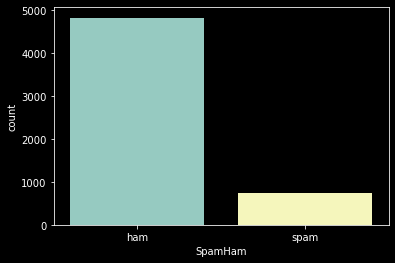

In [48]:
sns.countplot(df["SpamHam"])

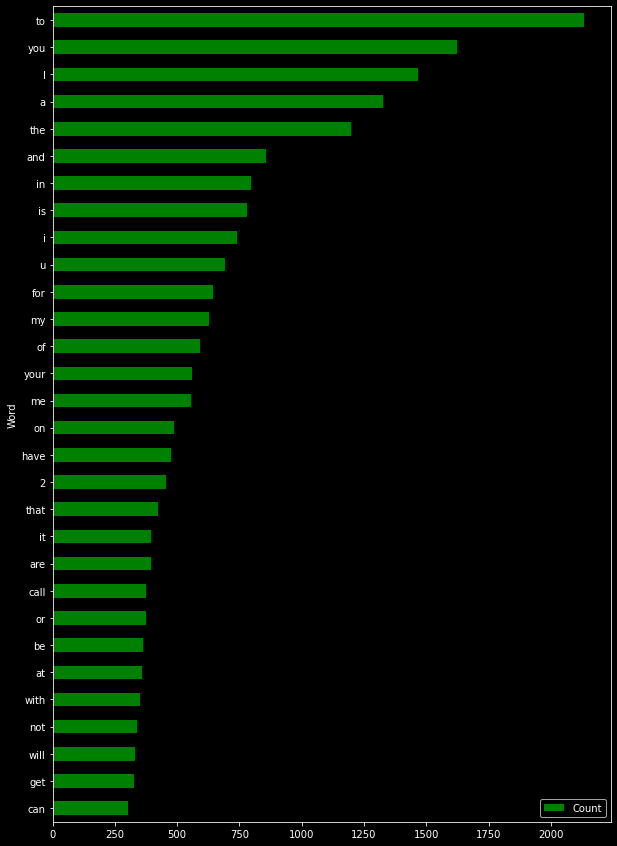

In [49]:
def word_count_plot(df):
     
     word_counter = collections.Counter([word for sentence in df for word in sentence.split()])
     most_count = word_counter.most_common(30) 

     most_count = pd.DataFrame(most_count, columns=["Word", "Count"]).sort_values(by="Count")
     most_count.plot.barh(x = "Word", y = "Count", color="green", figsize=(10, 15))
word_count_plot(df["Tweet"])

In [50]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Preprocessing - lemmatization

In [51]:
lem = WordNetLemmatizer()
def preprocessing(df):
      sms = contractions.fix(df) 
      sms = sms.lower() 
      sms = re.sub(r'https?://S+|www.S+', "", sms).strip() 
      sms = re.sub("[^a-z ]", "", sms) 
      sms = sms.split() 
     
      sms = [lem.lemmatize(word) for word in sms if not word in set(stopwords.words("english"))]
      sms = " ".join(sms)
      return sms
X = df["Tweet"].apply(preprocessing)



Encoding the data

In [52]:
from sklearn.preprocessing import LabelEncoder
lb_enc = LabelEncoder()
y = lb_enc.fit_transform(df["SpamHam"])

Tokenizing our data and converting it into a numerical sequence

In [53]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X)
text_to_sequence = tokenizer.texts_to_sequences(X) 

In [54]:
for i in range(5):
           print("Text               : ",X[i] )
           print("Numerical Sequence : ", text_to_sequence[i])

Text               :  go jurong point crazy available bugis n great world la e buffet cine got amore wat
Numerical Sequence :  [3, 3575, 255, 549, 522, 1028, 35, 56, 236, 845, 80, 2411, 1029, 9, 3576, 70]
Text               :  ok lar joking wif oni
Numerical Sequence :  [6, 220, 1173, 328, 1539]
Text               :  free entry wkly comp win fa cup final tkts st may text fa receive entry questionstd txt ratetcs apply over
Numerical Sequence :  [5, 342, 582, 724, 92, 1540, 846, 478, 1541, 147, 175, 17, 1540, 221, 342, 2412, 23, 2413, 263, 2414]
Text               :  dun say early hor c already say
Numerical Sequence :  [142, 48, 256, 2415, 69, 75, 48]
Text               :  nah think go usf life around though
Numerical Sequence :  [774, 33, 3, 725, 86, 121, 195]


Find the index number of the corresponding words

In [55]:
tokenizer.index_word 

{1: 'call',
 2: 'get',
 3: 'go',
 4: 'know',
 5: 'free',
 6: 'ok',
 7: 'ltgt',
 8: 'day',
 9: 'got',
 10: 'want',
 11: 'come',
 12: 'like',
 13: 'love',
 14: 'going',
 15: 'good',
 16: 'time',
 17: 'text',
 18: 'send',
 19: 'message',
 20: 'need',
 21: 'one',
 22: 'today',
 23: 'txt',
 24: 'home',
 25: 'lor',
 26: 'see',
 27: 'sorry',
 28: 'stop',
 29: 'r',
 30: 'still',
 31: 'back',
 32: 'mobile',
 33: 'think',
 34: 'reply',
 35: 'n',
 36: 'take',
 37: 'tell',
 38: 'phone',
 39: 'new',
 40: 'week',
 41: 'later',
 42: 'da',
 43: 'hi',
 44: 'please',
 45: 'cannot',
 46: 'make',
 47: 'tomorrow',
 48: 'say',
 49: 'night',
 50: 'claim',
 51: 'well',
 52: 'thing',
 53: 'much',
 54: 'dear',
 55: 'oh',
 56: 'great',
 57: 'hey',
 58: 'pls',
 59: 'would',
 60: 'give',
 61: 'number',
 62: 'way',
 63: 'happy',
 64: 'friend',
 65: 'work',
 66: 'hope',
 67: 'u',
 68: 'let',
 69: 'c',
 70: 'wat',
 71: 'prize',
 72: 'right',
 73: 'yes',
 74: 'min',
 75: 'already',
 76: 'ask',
 77: 'really',
 78: 'yea

In [56]:
max_length_sequence = max([len(i) for i in text_to_sequence])

padded_sms_sequence = pad_sequences(text_to_sequence, maxlen=max_length_sequence, 
                                    padding = "pre") 
padded_sms_sequence

array([[   0,    0,    0, ...,    9, 3576,   70],
       [   0,    0,    0, ..., 1173,  328, 1539],
       [   0,    0,    0, ..., 2413,  263, 2414],
       ...,
       [   0,    0,    0, ..., 1024, 7818, 3573],
       [   0,    0,    0, ...,  789,   67,    5],
       [   0,    0,    0, ..., 2147,  363,  145]])

Create model and add layers

In [57]:
TOT_SIZE = len(tokenizer.word_index)+1
def create_model():
    
      lstm_model = Sequential()
      lstm_model.add(Embedding(TOT_SIZE, 32, input_length=max_length_sequence))
      lstm_model.add(LSTM(100))
      lstm_model.add(Dropout(0.4))
      lstm_model.add(Dense(20, activation="relu"))
      lstm_model.add(Dropout(0.3))
      lstm_model.add(Dense(1, activation = "sigmoid"))
      return lstm_model
lstm_model = create_model()
lstm_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [58]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 79, 32)            250240    
                                                                 
 lstm_1 (LSTM)               (None, 100)               53200     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 20)                2020      
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 305,481
Trainable params: 305,481
Non-tr

Fit the model

In [59]:
lstm_model.fit(padded_sms_sequence, y, epochs = 5, validation_split=0.2, batch_size=16)

Epoch 1/5
279/279 [==============================] - 17s 47ms/step - loss: 0.2050 - accuracy: 0.9365 - val_loss: 0.0642 - val_accuracy: 0.9776
Epoch 2/5
279/279 [==============================] - 12s 44ms/step - loss: 0.0431 - accuracy: 0.9870 - val_loss: 0.0575 - val_accuracy: 0.9830
Epoch 3/5
279/279 [==============================] - 12s 43ms/step - loss: 0.0192 - accuracy: 0.9962 - val_loss: 0.0632 - val_accuracy: 0.9848
Epoch 4/5
279/279 [==============================] - 13s 45ms/step - loss: 0.0096 - accuracy: 0.9984 - val_loss: 0.0865 - val_accuracy: 0.9848
Epoch 5/5
279/279 [==============================] - 13s 45ms/step - loss: 0.0057 - accuracy: 0.9984 - val_loss: 0.0820 - val_accuracy: 0.9857


Saving the model

In [60]:
lstm_model.save('Spam_message_classifier.h5')

Test the model

In [92]:
X = df.Tweet
Y = df.SpamHam
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [129]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [130]:
test_sequences=tok.texts_to_sequences(X_test)
test_sequences_matrix=pad_sequences(test_sequences,maxlen=max_len)

In [131]:
accuracy = lstm_model.evaluate(test_sequences_matrix,Y_test)

27/27 [==============================] - 2s 55ms/step - loss: 1.1205 - accuracy: 0.8577
